In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
from scipy.ndimage import rotate, zoom
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from keras import models, layers, losses, optimizers, Model

2023-11-04 03:15:56.873991: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 03:15:56.874061: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 03:15:56.874115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gc.collect()

22

In [3]:
%matplotlib widget

def pickle_pi_set(pi, rng=range(359), plot=False, save=True):
    if not os.path.exists("pickles"):
        os.mkdir("pickles")

    pi_set = []
    mat_i = loadmat(f"mats/data-science-P{pi+1}.mat")
    coord_to_col = mat_i["meta"][0][0][8]
    data = mat_i["data"]
    info = mat_i["info"][0]

    for i in tqdm(rng, desc=str(pi)):
        datum = data[i][0][0]

        scan = np.zeros((23, 61, 51))
        for x in range(51):
            for y in range(61):
                for z in range(23):
                    scan[z, y, x] = datum[coord_to_col[x, y, z] - 1]

        mask = scan != mode(scan.flat).mode

        masked_scan = scan[mask]
        mask_mean, mask_std = np.mean(masked_scan), np.std(masked_scan)
        lt_mask, gt_mask = masked_scan < mask_mean, masked_scan > mask_mean
        std_left = np.sqrt(np.sum(np.square(masked_scan[lt_mask] - mask_mean)) / np.size(masked_scan[lt_mask]))
        std_right = np.sqrt(np.sum(np.square(masked_scan[gt_mask] - mask_mean)) / np.size(masked_scan[gt_mask]))

        scan[mask] -= mask_mean
        scan[mask][scan[mask] < mask_mean] /= std_left
        scan[mask][scan[mask] > mask_mean] /= std_right

        n = 2.5
        scan[scan > n * mask_std] = n * mask_std
        scan[scan < -n * mask_std] = -n * mask_std
        scan[scan == mode(scan.flat).mode] = scan[mask].min()

        scan[scan < 0] /= abs(scan.min())
        scan[scan > 0] /= scan.max()
        
        pi_set.append((scan, info[i][2][0]))

    if save:
        with open(f"pickles/{pi}.pkl", "wb") as f:
            pickle.dump(pi_set, f)
    
    

    if plot:
        scan = (scan - scan.min()) / (scan.max() - scan.min())

        voxels = scan[scan != scan.min()]
        indices = np.nonzero(scan)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.set_xticks([]) or ax.set_yticks([]) or ax.set_zticks([])

        ax.scatter(indices[0], indices[1], indices[2], c=voxels, alpha=voxels, cmap="twilight", s=30, marker="s")
        plt.show()

        w = 5
        fig, ax = plt.subplots(w, w, constrained_layout=True)
        fig.dpi = 100
        bg_color = (225 / 255, 216 / 255, 226 / 255)
        fig.set_facecolor(bg_color)

        for j in range(23):
            ax[(j - j % w) // w, j % w].imshow(scan[j], vmin=0, vmax=1, cmap="twilight")
            ax[(j - j % w) // w, j % w].set_xticks([])
            ax[(j - j % w) // w, j % w].set_yticks([])
            plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

        ax[4, 3].axis("off") and ax[4, 4].axis("off")
        plt.show()


0: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


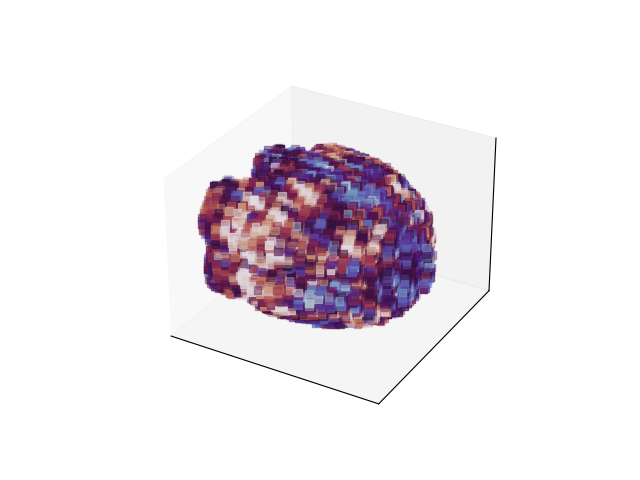

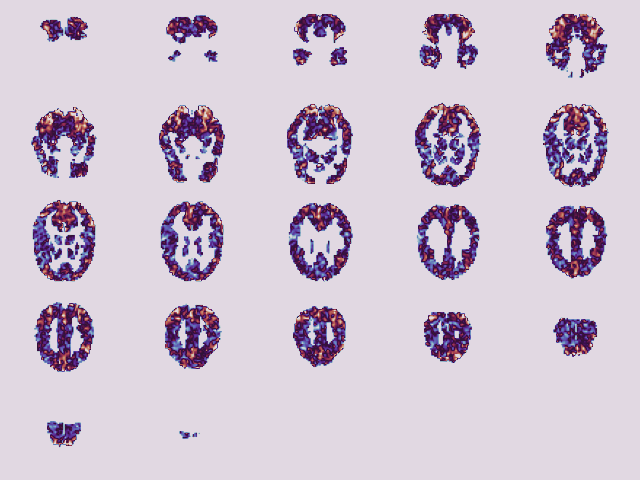

In [4]:
pickle_pi_set(0, range(359, 360), True, False)

In [5]:
def pickle_set():
    Pool(processes=5).map(pickle_pi_set, range(9))

# pickle_set()

In [6]:
NUM_CLASSES = 60

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(5)]
targets = set([pickles[0][i][1] for i in range(len(pickles[0]))])

targets = list(targets)[:NUM_CLASSES]
targets = {k: v for k, v in zip(targets, [[1 if i == j else 0 for i in range(NUM_CLASSES)] for j in range(len(targets))])}

pickles = [item for sublist in pickles for item in sublist if item[1] in targets]
print(len(pickles))

split = int(0.8 * len(pickles))
trains, tests = pickles[:split], pickles[split:]

train_x = np.array([train[0] for train in trains])
train_y = np.array([train[1] for train in trains])

test_x = [test[0] for test in tests]
test_y = [test[1] for test in tests]

del pickles, trains, tests

1795


In [7]:
def get_sample(i, train=True):
    i = random.randint(0, len(train_x) - 1)

    x, y = ((train_x, train_y) if train else (test_x, test_y))
    scan, target = x[i], y[i]
    
    angles = np.random.randint(low=-5, high=5, size=(3, ))
    scan = rotate(scan, angles[0], (0, 1))
    scan = rotate(scan, angles[1], (1, 2))
    scan = rotate(scan, angles[2], (2, 0))

    scan = zoom(scan, [64 / s for s in scan.shape])
    
    scan = np.expand_dims(scan, -1)
    target = targets[target]

    return scan, target

In [8]:
def get_batch(batch_size=32, train=True):
    
    samples = list(Pool(processes=8).imap(get_sample, zip(range(batch_size), [train] * batch_size)))
    batch_x = [sample[0] for sample in samples]
    batch_y = [sample[1] for sample in samples]

    return np.array(batch_x), np.array(batch_y)

In [9]:
def get_model():
    inputs = layers.Input((64, 64, 64, 1))
    x = layers.Conv3D(8, 16, 1, activation="tanh")(inputs)
    x = layers.Conv3D(8, 8, 1, activation="tanh")(x)
    x = layers.Conv3D(8, 8, 1, activation="tanh")(x)
    x = layers.Conv3D(8, 8, 1, activation="tanh")(x)
    x = layers.Conv3D(8, 8, 1, activation="tanh")(x)
    x = layers.Conv3D(16, 8, 1, activation="tanh")(x)
    x = layers.Conv3D(32, 8, 1, activation="tanh")(x)
    x = layers.Conv3D(64, 4, 1, activation="tanh")(x)
    x = layers.Conv3D(128, 4, 1, activation="tanh")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=x)
    model.summary()
    
    return model

In [10]:
model = get_model()
opt = optimizers.Adam()
loss = losses.CategoricalCrossentropy()

def train():
    model.compile(opt, loss)

    for i in range(1000):

        with tf.GradientTape() as tape:
            batch_x, batch_y = get_batch(32)
            pred_y = model(batch_x)

            batchloss = loss(batch_y, pred_y)
            grad = tape.gradient(batchloss, model.trainable_variables)
            opt.apply_gradients(zip(grad, model.trainable_variables))

            print(i, float(batchloss))

        if i % 100 == 0 and i != 0:
            batch_x, batch_y = get_batch(512, train=True)
            model.evaluate(batch_x, batch_y, batch_size=1)

train()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 49, 49, 49, 8)     32776     
                                                                 
 conv3d_1 (Conv3D)           (None, 42, 42, 42, 8)     32776     
                                                                 
 conv3d_2 (Conv3D)           (None, 35, 35, 35, 8)     32776     
                                                                 
 conv3d_3 (Conv3D)           (None, 28, 28, 28, 8)     32776     
                                                                 
 conv3d_4 (Conv3D)           (None, 21, 21, 21, 8)     32776     
                                                                 
 conv3d_5 (Conv3D)           (None, 14, 14, 14, 16)    65552 